# Moisture Magic 💦 🧙‍♂️
## EDA of UFZ Dataset Soil Moisture "Hohes Holz" → 📈📊

**HIDA 2020 Hackthon, 2020-11-06**

Maximilian Graf [[@Max_Grave_]](https://twitter.com/max_grafe_/), Alexander Merdian-Tarko, Julius Polz [[@jpolz3]](https://twitter.com/jpolz3/), Christian Werner [[@cwerner76]](https://twitter.com/cwerner76/)  
Source: https://github.com/HIDA-Datathon/moisturemagic.git

In [1]:
import numpy as np
import pandas as pd

In [2]:
import datashader as ds
import datashader.transfer_functions as tf

In [3]:
import sys
sys.path.insert(0,'/p/home/jusers/merdian-tarko1/jusuf/lib/python3.6/site-packages')
import xarray as xr

In [4]:
# read raw data and convert datetime
#df = pd.read_csv("/glacier2/dldatasets/hida2020-ufz-data/00_data.csv", delim_whitespace=True)
df = pd.read_csv("/p/home/jusers/merdian-tarko1/jusuf/PROJECT_training2005/ufz_qc_challenge/00_data.csv", delim_whitespace=True)
df['Date.Time'] = pd.to_datetime(df['Date.Time'])
df.head(2)

,,Time,Box,Date.Time,SM1,SM1_Flag,Temp1,Temp1_Flag,SM2,SM2_Flag,Temp2,...,SM6_Flag,Temp6,Temp6_Flag,BattV,SM1_Depth,SM2_Depth,SM3_Depth,SM4_Depth,SM5_Depth,SM6_Depth
1.2,2012-07-19,17:45:53,1,2012-07-19 17:45:53,-2.8240,Auto:Range,18.2580,OK,-5.9817,Auto:Range,18.2232,...,Auto:Range,18.3623,OK,3599,0.05,0.05,0.05,0.05,0.05,0.05
2.2,2010-10-03,02:07:00,2,2010-10-03 02:07:00,29.9656,OK,5.0416,OK,-4.8066,Auto:Range,-15.1656,...,OK,5.7372,OK,3138,0.10,0.20,0.30,0.40,0.50,0.60


### 1. Initial cleanup

Steps:  
* drop columns not needed for analysis
* eliminate Box1 (located in first row) since it only has one measly measurement...
* rename some columns
* make time the index

In [5]:
df = df.reset_index().drop(['level_0','level_1','Time'], axis=1).iloc[1:,:]
df = df.rename(columns={'Box': 'box', 'Date.Time': 'time'})
df = df.set_index('time')
df.head(2)

,box,SM1,SM1_Flag,Temp1,Temp1_Flag,SM2,SM2_Flag,Temp2,Temp2_Flag,SM3,...,SM6_Flag,Temp6,Temp6_Flag,BattV,SM1_Depth,SM2_Depth,SM3_Depth,SM4_Depth,SM5_Depth,SM6_Depth
time,,,,,,,,,,,,,,,,,,,,,
2010-10-03 02:07:00,2,29.9656,OK,5.0416,OK,-4.8066,Auto:Range,-15.1656,OK,-7.6653,...,OK,5.7372,OK,3138,0.1,0.2,0.3,0.4,0.5,0.6
2010-10-03 03:07:00,2,26.1448,OK,8.4848,OK,23.7972,OK,7.7544,OK,125.1174,...,Auto:Spike,6.8154,OK,3496,0.1,0.2,0.3,0.4,0.5,0.6


### 2. Resample to consistent 15min intervals

In [6]:
df = df.groupby('box').resample('15min').first().drop('box', axis=1)

### 3. Reshape dataframe (wide to short form)

Steps:
* split into variable groups
* ignore depth (we use level for vertical stratification)
* rename columns to level id for later melt
* melt to narrow df form
* convert to xarray dataset

In [7]:
# split df for variable groups
def expand_name(var, flag=False):
    f = '_Flag' if flag else ''
    return [f"{var}{i}{f}" for i in range(1,7)]

df_sm = df[expand_name('SM')]
df_temp = df[expand_name('Temp')]
df_bat = df[['BattV']]

# and quality flags
df_sm_qa = df[expand_name('SM', flag=True)]
df_temp_qa = df[expand_name('Temp', flag=True)]

# rename columns
for d in [df_sm, df_temp, df_sm_qa, df_temp_qa]:
    d.columns = list(range(1,7))

# melt
df_sm = pd.melt(df_sm.reset_index(), id_vars=['box','time']).set_index(['time','box'])
df_temp = pd.melt(df_temp.reset_index(), id_vars=['box','time']).set_index(['time','box'])
df_sm_qa = pd.melt(df_sm_qa.reset_index(), id_vars=['box','time']).set_index(['time','box'])
df_temp_qa = pd.melt(df_temp_qa.reset_index(), id_vars=['box','time']).set_index(['time','box'])

# rename new columns
df_sm.columns = ['level', 'soilmoisture']
df_temp.columns = ['level', 'soiltemp']
df_sm_qa.columns = ['level', 'soilmoisture_flag']
df_temp_qa.columns = ['level', 'soiltemp_flag']

# add level to multi-index
df_sm = df_sm.set_index('level', append=True)
df_temp = df_temp.set_index('level', append=True)
df_sm_qa = df_sm_qa.set_index('level', append=True)
df_temp_qa = df_temp_qa.set_index('level', append=True)

# convert dtype of categorical columns
df_sm_qa['soilmoisture_flag'] = df_sm_qa['soilmoisture_flag'].astype('category')
df_temp_qa['soiltemp_flag'] = df_temp_qa['soiltemp_flag'].astype('category')

df_sm_qa.head(2)

,,,soilmoisture_flag
time,box,level,
2010-10-03 02:00:00,2,1,OK
2010-10-03 02:15:00,2,1,NaN


In [8]:
display(df_sm_qa['soilmoisture_flag'].cat.categories)
display(np.unique(df_sm_qa['soilmoisture_flag'].cat.codes))

Index(['Auto:BattV', 'Auto:Range', 'Auto:Spike', 'Manual', 'OK'], dtype='object')

array([-1,  0,  1,  2,  3,  4], dtype=int8)

### 4. Convert to xarray dataset

In [9]:
ds = pd.concat([df_sm, df_temp, df_sm_qa, df_temp_qa], axis=1).to_xarray()

ds['soiltemp'].attrs['long_name'] = "soil temperature"
ds['soiltemp'].attrs['units'] = "deg C"
ds['soilmoisture'].attrs['long_name'] = "soil moisture"
ds['soilmoisture'].attrs['units'] = "vol percent"

ds['soiltemp_flag'].attrs['long_name'] = "soil temperature qa flag"
ds['soiltemp_flag'].attrs['units'] = "category"
ds['soiltemp_flag'].attrs['flag_values'] = ','.join([str(x) for x in np.unique(df_temp_qa['soiltemp_flag'].cat.codes.values)[1:]])
ds['soiltemp_flag'].attrs['flag_meanings'] = ' '.join(df_temp_qa['soiltemp_flag'].cat.categories.values.tolist())
   
ds['soilmoisture_flag'].attrs['long_name'] = "soil moisture qa flag"
ds['soilmoisture_flag'].attrs['units'] = "category"
ds['soilmoisture_flag'].attrs['flag_values'] = ','.join([str(x) for x in np.unique(df_sm_qa['soilmoisture_flag'].cat.codes.values)[1:]])
ds['soilmoisture_flag'].attrs['flag_meanings'] = ' '.join(df_sm_qa['soilmoisture_flag'].cat.categories.values.tolist())

ds

<xarray.Dataset>
Dimensions:            (box: 39, level: 6, time: 302043)
Coordinates:
  * time               (time) datetime64[ns] 2010-09-30T02:00:00 ... 2019-05-...
  * box                (box) int64 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
  * level              (level) int64 1 2 3 4 5 6
Data variables:
    soilmoisture       (time, box, level) float64 nan nan nan ... -13.3 45.43
    soiltemp           (time, box, level) float64 nan nan nan ... -15.55 7.928
    soilmoisture_flag  (time, box, level) object nan nan ... 'Manual'
    soiltemp_flag      (time, box, level) object nan nan nan ... 'Manual' 'OK'

In [10]:
df_bat = df[['BattV']]
df_bat = df_bat.reset_index()
df_bat.columns = ['box', 'time','battery']
df_bat = df_bat.set_index(['time', 'box'])
ds_bat = df_bat.to_xarray()

ds_bat.attrs['long_name'] = "battery voltage"
ds_bat.attrs['units'] = "mV"

ds_bat

<xarray.Dataset>
Dimensions:  (box: 39, time: 302043)
Coordinates:
  * time     (time) datetime64[ns] 2010-09-30T02:00:00 ... 2019-05-12T08:30:00
  * box      (box) int64 2 3 4 5 6 7 8 9 10 11 ... 31 32 33 34 35 36 37 38 39 40
Data variables:
    battery  (time, box) float64 nan nan nan ... 3.47e+03 3.248e+03 3.392e+03
Attributes:
    long_name:  battery voltage
    units:      mV

In [11]:
ds = xr.merge([ds, ds_bat])
ds

<xarray.Dataset>
Dimensions:            (box: 39, level: 6, time: 302043)
Coordinates:
  * time               (time) datetime64[ns] 2010-09-30T02:00:00 ... 2019-05-...
  * box                (box) int64 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
  * level              (level) int64 1 2 3 4 5 6
Data variables:
    soilmoisture       (time, box, level) float64 nan nan nan ... -13.3 45.43
    soiltemp           (time, box, level) float64 nan nan nan ... -15.55 7.928
    soilmoisture_flag  (time, box, level) object nan nan ... 'Manual'
    soiltemp_flag      (time, box, level) object nan nan nan ... 'Manual' 'OK'
    battery            (time, box) float64 nan nan nan ... 3.248e+03 3.392e+03

In [12]:
#ds.to_netcdf("ufz_hohes-holz.nc")

In [13]:
#! ls -lh

## Visualization of Yearly Occurrences of Soil Moisture and Temperature Flags

### Data preparation

In [14]:
import gc
import matplotlib.pyplot as plt

In [15]:
gc.collect()

5192

Transform xarray back to pandas dataframe

In [16]:
df = ds.to_dataframe().reset_index()

In [17]:
df.shape

(70678062, 8)

In [18]:
df.head()

,box,level,time,soilmoisture,soiltemp,soilmoisture_flag,soiltemp_flag,battery
0,2,1,2010-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN
1,2,1,2010-09-30 02:15:00,NaN,NaN,NaN,NaN,NaN
2,2,1,2010-09-30 02:30:00,NaN,NaN,NaN,NaN,NaN
3,2,1,2010-09-30 02:45:00,NaN,NaN,NaN,NaN,NaN
4,2,1,2010-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN


General availability of box data that is not all missing (based on soil moisture availability, min and max datetime per box)

In [19]:
df[df['soilmoisture'].notna()].groupby('box').agg({'time': ['min', 'max']})

time                    
                    min                 max
box                                        
2   2010-10-03 02:00:00 2016-03-22 04:30:00
3   2010-10-03 02:00:00 2016-03-03 10:15:00
4   2010-10-05 16:00:00 2019-05-12 08:30:00
5   2012-07-19 20:45:00 2013-12-01 07:45:00
6   2010-09-30 02:00:00 2019-05-12 08:30:00
7   2010-10-03 02:00:00 2019-05-12 08:30:00
8   2010-09-30 02:00:00 2014-02-27 02:00:00
9   2012-07-19 19:45:00 2013-08-09 16:30:00
10  2012-07-19 19:30:00 2016-03-17 04:00:00
11  2010-10-03 04:00:00 2015-10-13 06:30:00
12  2010-10-05 11:00:00 2017-01-30 14:45:00
13  2010-09-30 03:00:00 2019-05-12 08:30:00
14  2012-07-19 19:45:00 2016-07-26 23:30:00
15  2012-07-19 19:45:00 2019-05-12 08:30:00
16  2010-10-03 14:00:00 2016-10-02 00:00:00
17  2012-07-19 19:45:00 2016-09-30 14:00:00
18  2012-07-19 18:30:00 2016-04-27 21:00:00
19  2012-07-24 16:15:00 2013-12-12 10:00:00
20  2010-10-02 21:00:00 2016-11-17 15:30:00
21  2012-07-19 18:15:00 2016-12-31 19:15:00
22  2012-07-19 17:30:00 2017-03-24 01:00:00
23  2012-07-19 17:15:00 2017-05-16 13:00:00
24  2012-07-19 18:30:00 2019-05-12 08:30:00
25  2012-07-19 17:30:00 2017-03-29 07:45:00
26  2010-10-03 00:00:00 2019-05-12 08:30:00
27  2010-10-12 01:00:00 2019-05-12 08:30:00
28  2012-07-19 18:45:00 2017-03-16 08:00:00
29  2012-07-19 20:15:00 2019-05-12 08:30:00
30  2012-07-24 16:30:00 2016-02-21 06:00:00
31  2012-07-19 17:45:00 2017-01-11 21:15:00
32  2012-07-19 18:15:00 2017-04-06 09:00:00
33  2010-10-03 15:00:00 2016-03-30 07:30:00
34  2010-10-03 03:00:00 2019-05-12 08:30:00
35  2010-09-30 03:00:00 2019-05-12 08:30:00
36  2012-07-19 18:30:00 2019-05-12 08:30:00
37  2010-10-05 16:00:00 2019-05-12 08:30:00
38  2010-10-03 02:00:00 2019-05-12 08:30:00
39  2013-06-06 13:00:00 2019-05-12 08:30:00
40  2013-06-25 10:45:00 2019-05-12 08:30:00

Number of missing values per box

In [20]:
df[df['soilmoisture'].isna()].groupby('box').count()

,level,time,soilmoisture,soiltemp,soilmoisture_flag,soiltemp_flag,battery
box,,,,,,,
2,1122051,1122051,0,3807,3807,3807,3807
3,1161473,1161473,0,39677,39677,39677,39677
4,764574,764574,0,187506,187506,187506,187506
5,1558974,1558974,0,156,156,156,156
6,722423,722423,0,35891,35891,35891,35891
7,569413,569413,0,33181,33181,33181,33181
8,1524342,1524342,0,36,36,36,36
9,1627204,1627204,0,2338,2338,2338,2338
10,1258657,1258657,0,123541,123541,123541,123541


The combined information from the two tables above allows to select boxes that have not a too excessive amount of missing values during their period of operation. This information can be used for future analyses.

Examine soil moisture and temperature flags unique values

In [21]:
df.soilmoisture_flag.unique()

array([nan, 'OK', 'Auto:Spike', 'Auto:Range', 'Manual', 'Auto:BattV'],
      dtype=object)

In [22]:
df.soiltemp_flag.unique()

array([nan, 'OK', 'Auto:Spike', 'Auto:Range', 'Manual', 'Auto:BattV'],
      dtype=object)

Fill soil moisture and temperature flags missing values with string to make it countable in the following

In [23]:
df.soilmoisture_flag = df.soilmoisture_flag.fillna('Missing')
df.soiltemp_flag = df.soiltemp_flag.fillna('Missing')

Make dummies from soil moisture and temperature flags to make the flags occurrences easily countable

In [24]:
df = pd.get_dummies(df, columns=['soilmoisture_flag', 'soiltemp_flag'])

In [25]:
df.shape

(70678062, 18)

In [26]:
df.head()

,box,level,time,soilmoisture,soiltemp,battery,soilmoisture_flag_Auto:BattV,soilmoisture_flag_Auto:Range,soilmoisture_flag_Auto:Spike,soilmoisture_flag_Manual,soilmoisture_flag_Missing,soilmoisture_flag_OK,soiltemp_flag_Auto:BattV,soiltemp_flag_Auto:Range,soiltemp_flag_Auto:Spike,soiltemp_flag_Manual,soiltemp_flag_Missing,soiltemp_flag_OK
0,2,1,2010-09-30 02:00:00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,1,0
1,2,1,2010-09-30 02:15:00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,1,0
2,2,1,2010-09-30 02:30:00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,1,0
3,2,1,2010-09-30 02:45:00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,1,0
4,2,1,2010-09-30 03:00:00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,1,0


Compute yearly aggregate for soil moisture and temperature flags dummies

In [27]:
df_agg = df[['time',
             'soilmoisture_flag_Auto:BattV',
             'soilmoisture_flag_Auto:Range',
             'soilmoisture_flag_Auto:Spike',
             'soilmoisture_flag_Manual',
             'soilmoisture_flag_Missing',
             'soilmoisture_flag_OK',
             'soiltemp_flag_Auto:BattV',
             'soiltemp_flag_Auto:Range',
             'soiltemp_flag_Auto:Spike',
             'soiltemp_flag_Manual',
             'soiltemp_flag_Missing',
             'soiltemp_flag_OK']].set_index('time').resample('Y').sum()

In [28]:
df_agg.shape

(10, 12)

In [29]:
df_agg.head()

,soilmoisture_flag_Auto:BattV,soilmoisture_flag_Auto:Range,soilmoisture_flag_Auto:Spike,soilmoisture_flag_Manual,soilmoisture_flag_Missing,soilmoisture_flag_OK,soiltemp_flag_Auto:BattV,soiltemp_flag_Auto:Range,soiltemp_flag_Auto:Spike,soiltemp_flag_Manual,soiltemp_flag_Missing,soiltemp_flag_OK
time,,,,,,,,,,,,
2010-12-31,36.0,1204.0,552.0,0.0,2080038.0,5450.0,36.0,354.0,991.0,0.0,2080038.0,5861.0
2011-12-31,0.0,366.0,219.0,0.0,8197080.0,1695.0,0.0,107.0,277.0,0.0,8197080.0,1896.0
2012-12-31,0.0,55283.0,39504.0,0.0,5585976.0,2541061.0,0.0,6663.0,24956.0,0.0,5585976.0,2604229.0
2013-12-31,28494.0,296965.0,46672.0,103405.0,1931154.0,5792670.0,28494.0,23073.0,59992.0,65546.0,1931154.0,6091101.0
2014-12-31,354120.0,1019652.0,28034.0,531482.0,1701906.0,4564166.0,354120.0,222629.0,49177.0,830818.0,1701906.0,5040710.0


### Soil moisture flags

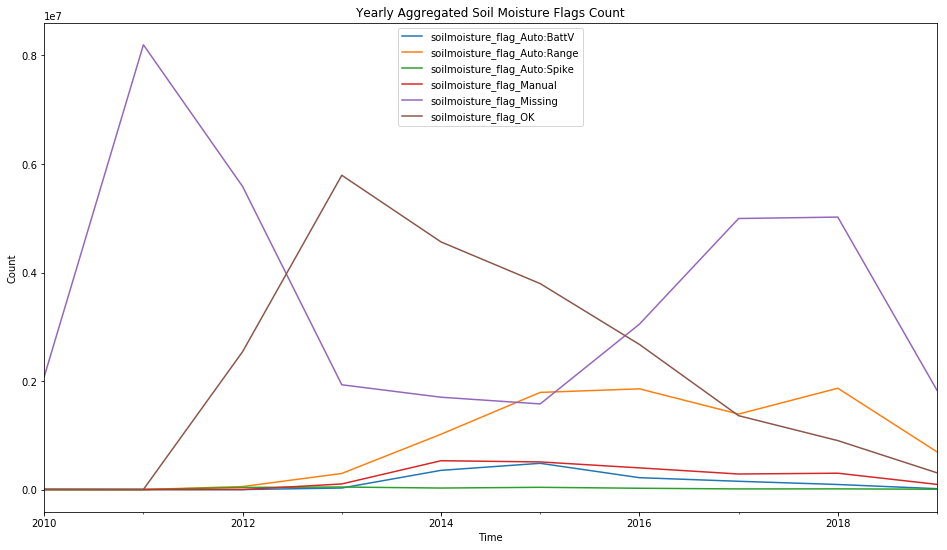

In [36]:
df_agg[['soilmoisture_flag_Auto:BattV', 'soilmoisture_flag_Auto:Range', 'soilmoisture_flag_Auto:Spike', 'soilmoisture_flag_Manual', 'soilmoisture_flag_Missing', 'soilmoisture_flag_OK']].plot(figsize=(16,9))
plt.title('Yearly Aggregated Soil Moisture Flags Count')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.show()

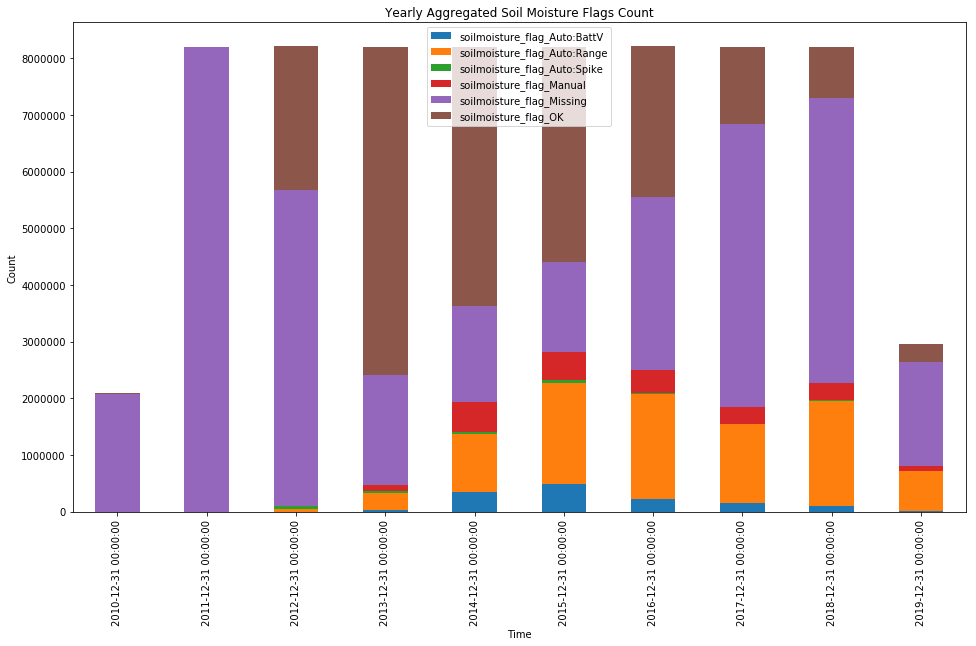

In [37]:
df_agg[['soilmoisture_flag_Auto:BattV', 'soilmoisture_flag_Auto:Range', 'soilmoisture_flag_Auto:Spike', 'soilmoisture_flag_Manual', 'soilmoisture_flag_Missing', 'soilmoisture_flag_OK']].plot(kind='bar', stacked=True, figsize=(16,9))
plt.title('Yearly Aggregated Soil Moisture Flags Count')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.show()

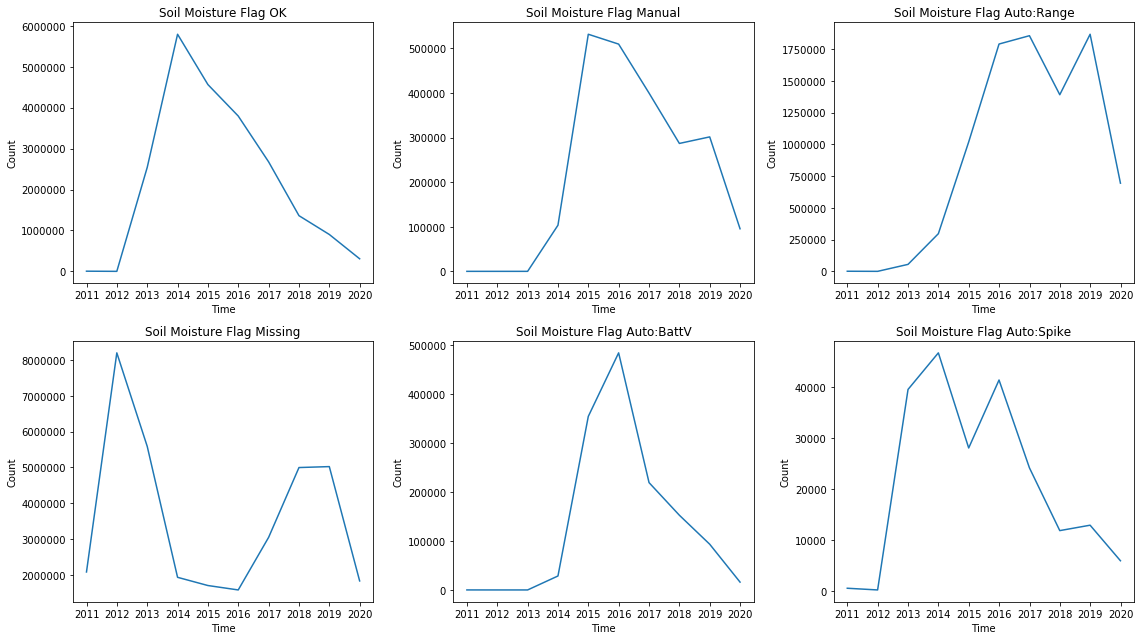

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))

x = df_agg.index

axs[0, 0].plot(x, df_agg['soilmoisture_flag_OK'])
axs[0, 0].set_title('Soil Moisture Flag OK')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Count')

axs[1, 0].plot(x, df_agg['soilmoisture_flag_Missing'])
axs[1, 0].set_title('Soil Moisture Flag Missing')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Count')

axs[0, 1].plot(x, df_agg['soilmoisture_flag_Manual'])
axs[0, 1].set_title('Soil Moisture Flag Manual')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Count')

axs[1, 1].plot(x, df_agg['soilmoisture_flag_Auto:BattV'])
axs[1, 1].set_title('Soil Moisture Flag Auto:BattV')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Count')

axs[0, 2].plot(x, df_agg['soilmoisture_flag_Auto:Range'])
axs[0, 2].set_title('Soil Moisture Flag Auto:Range')
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Count')

axs[1, 2].plot(x, df_agg['soilmoisture_flag_Auto:Spike'])
axs[1, 2].set_title('Soil Moisture Flag Auto:Spike')
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Count')

fig.tight_layout()

### Soil temperature flags

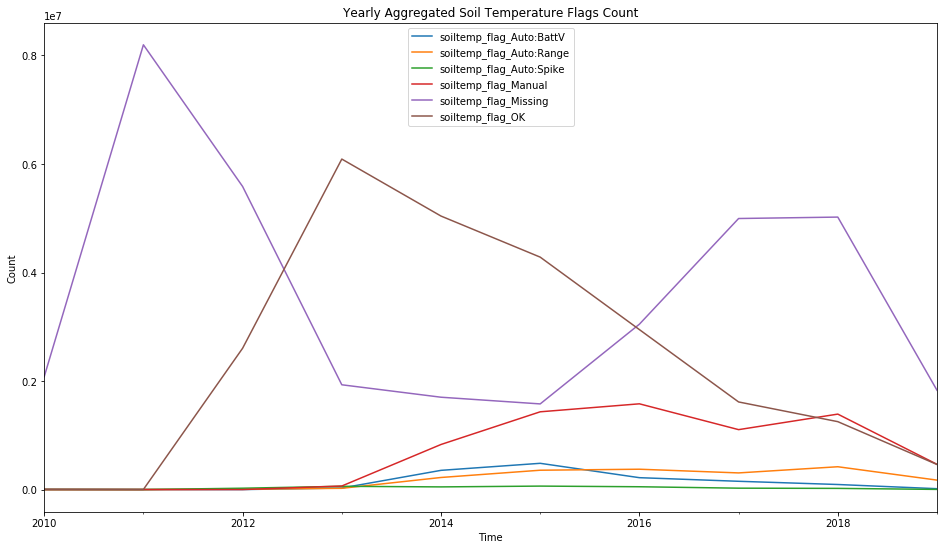

In [39]:
df_agg[['soiltemp_flag_Auto:BattV', 'soiltemp_flag_Auto:Range', 'soiltemp_flag_Auto:Spike', 'soiltemp_flag_Manual', 'soiltemp_flag_Missing', 'soiltemp_flag_OK']].plot(figsize=(16,9))
plt.title('Yearly Aggregated Soil Temperature Flags Count')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.show()

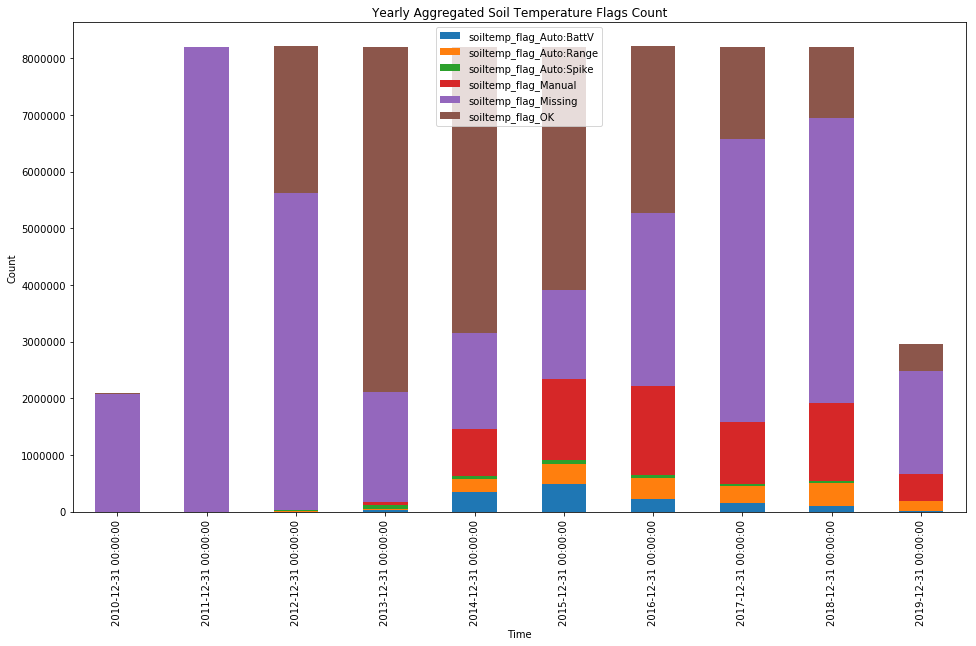

In [40]:
df_agg[['soiltemp_flag_Auto:BattV', 'soiltemp_flag_Auto:Range', 'soiltemp_flag_Auto:Spike', 'soiltemp_flag_Manual', 'soiltemp_flag_Missing', 'soiltemp_flag_OK']].plot(kind='bar', stacked=True, figsize=(16,9))
plt.title('Yearly Aggregated Soil Temperature Flags Count')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='upper center')
plt.show()

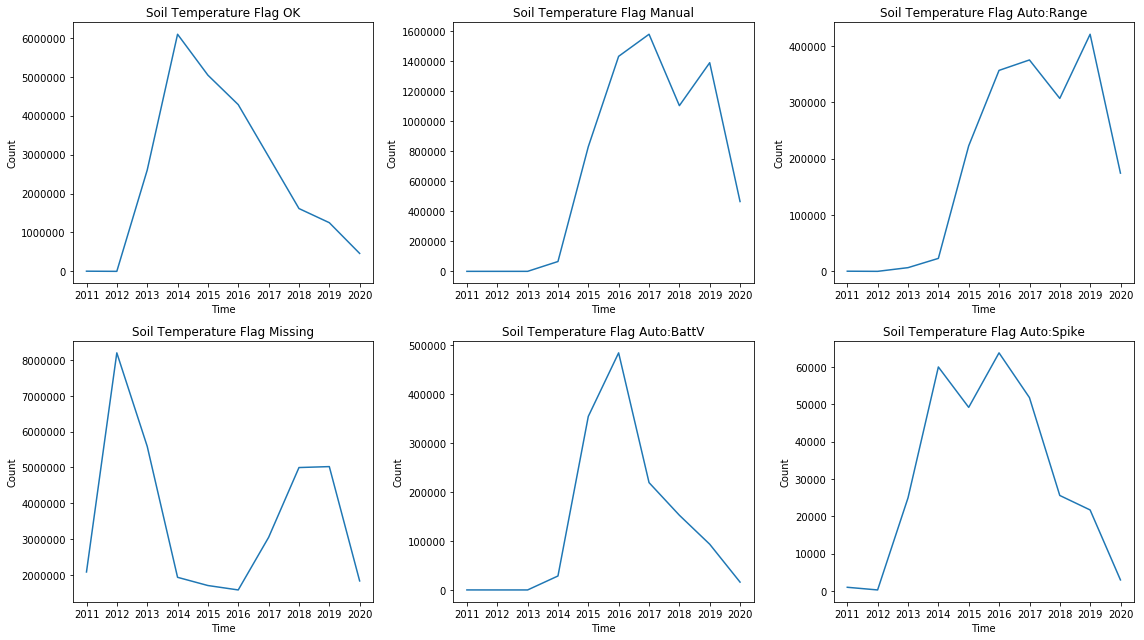

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))

x = df_agg.index

axs[0, 0].plot(x, df_agg['soiltemp_flag_OK'])
axs[0, 0].set_title('Soil Temperature Flag OK')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Count')

axs[1, 0].plot(x, df_agg['soiltemp_flag_Missing'])
axs[1, 0].set_title('Soil Temperature Flag Missing')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Count')

axs[0, 1].plot(x, df_agg['soiltemp_flag_Manual'])
axs[0, 1].set_title('Soil Temperature Flag Manual')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Count')

axs[1, 1].plot(x, df_agg['soiltemp_flag_Auto:BattV'])
axs[1, 1].set_title('Soil Temperature Flag Auto:BattV')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Count')

axs[0, 2].plot(x, df_agg['soiltemp_flag_Auto:Range'])
axs[0, 2].set_title('Soil Temperature Flag Auto:Range')
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Count')

axs[1, 2].plot(x, df_agg['soiltemp_flag_Auto:Spike'])
axs[1, 2].set_title('Soil Temperature Flag Auto:Spike')
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Count')

fig.tight_layout()

### Conclusion

The availability and quality of the data varies a lot over time. In order to allow for a good analysis and robust modeling it is important to select a period where the number of missing values is not to excessive and the number of manual flags, which we are interessted in detecting, is not to low. Thus, data from the years 2015 and 2016 appears to be the most suitable to proceed with.